In [1]:
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
import optax
import tqdm
from functools import partial

backend = "cpu"

In [2]:
class SpectralConv1d(nnx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
        self, in_channels: int, out_channels: int, modes: int, *, rngs=nnx.Rngs
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        key1 = rngs.params()
        key2 = rngs.params()
        self.modes = modes
        scale = 1.0 / (self.in_channels * self.out_channels * self.modes)
        self.real_weights = nnx.Param(
            jax.random.uniform(
                key1,
                (self.in_channels, self.out_channels, self.modes),
                minval=-scale,
                maxval=scale,
            )
        )
        self.imag_weights = nnx.Param(
            jax.random.uniform(
                key2,
                (self.in_channels, self.out_channels, self.modes),
                minval=-scale,
                maxval=scale,
            )
        )

    @nnx.jit
    def complex_mult1d(self, x: jax.Array, y: jax.Array) -> jax.Array:
        return jnp.einsum("bcM,coM->boM", x, y)

    def __call__(self, x: jax.Array):
        batch_size, channels, spatial_points = x.shape
        x_hat = jnp.fft.rfft(x, axis=-1)
        x_hat_under_modes = x_hat[:, :, : self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)
        # jax.debug.print("{out_hat_under_modes}", out_hat_under_modes=out_hat_under_modes.shape)
        out_hat = jnp.zeros(
            (batch_size, self.out_channels, x_hat.shape[-1]), dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :, : self.modes].set(out_hat_under_modes)
        out = jnp.fft.irfft(out_hat, n=spatial_points, axis=-1)
        return out


class FNOBlock1d(nnx.Module):
    """A single block of the Fourier Neural Operator."""

    spectral_conv: SpectralConv1d
    bypass_conv: nnx.Conv
    activation: Callable

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        modes: int,
        activation: Callable,
        *,
        rngs=nnx.Rngs
    ):
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes, rngs=rngs)
        self.bypass_conv = nnx.Conv(
            in_features=in_channels,
            out_features=out_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.activation = activation

    def __call__(self, x: jax.Array):
        # x shape: (batch_size, channels, spatial_points)
        # For bypass conv, we need to transpose to (batch_size, spatial_points, channels)
        x_transposed = x.transpose(0, 2, 1)  # (batch_size, spatial_points, channels)
        bypass_out = self.bypass_conv(
            x_transposed
        )  # (batch_size, spatial_points, out_channels)
        bypass_out = bypass_out.transpose(
            0, 2, 1
        )  # (batch_size, out_channels, spatial_points)

        return self.activation(self.spectral_conv(x) + bypass_out)


class FNO1d(nnx.Module):
    """Fourier Neural Operator for 1D data."""

    lifting_function: nnx.Conv
    projection_function: nnx.Conv
    fno_blocks: list[FNOBlock1d]
    rngs: nnx.Rngs

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        modes: int,
        num_blocks: int,
        activation: Callable,
        *,
        rngs=nnx.Rngs
    ):
        self.rngs = rngs
        # self.lifting_function = MLP(n_features=in_channels, n_hidden=hidden_channels,
        #                             n_layers=3, n_output=hidden_channels, dropout=0.1, rngs=rngs)
        # # Projection function to map back to output space
        # self.projection_function = MLP(n_features=hidden_channels, n_hidden=hidden_channels,
        #                                n_layers=3, n_output=out_channels, dropout=0.1, rngs=rngs)
        self.lifting_function = nnx.Conv(
            in_features=in_channels,
            out_features=hidden_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.projection_function = nnx.Conv(
            in_features=hidden_channels,
            out_features=out_channels,
            kernel_size=(1,),
            rngs=rngs,
        )
        self.fno_blocks = [
            FNOBlock1d(hidden_channels, hidden_channels, modes, activation, rngs=rngs)
            for _ in range(num_blocks)
        ]

    @nnx.jit
    def _forward_batched(self, x: jax.Array):
        """Forward pass for batched input (batch_size, spatial_points, channels)."""
        x = self.lifting_function(
            x
        )  # Shape: (batch_size, spatial_points, hidden_channels)
        x = x.transpose(0, 2, 1)  # Shape: (batch_size, hidden_channels, spatial_points)
        for block in self.fno_blocks:
            x = block(x)
        x = x.transpose(0, 2, 1)  # Shape: (batch_size, spatial_points, hidden_channels)
        x = self.projection_function(
            x
        )  # Shape: (batch_size, spatial_points, out_channels)
        return x

    @nnx.jit
    def _forward_single(self, x: jax.Array):
        """Forward pass for single input (spatial_points, channels)."""
        x = x[None, ...]  # Add batch dimension: (1, spatial_points, channels)
        x = self._forward_batched(x)
        return x[0]  # Remove batch dimension: (spatial_points, out_channels)

    def __call__(self, x: jax.Array):
        """Main forward pass - optimized for batched inputs (most common case)."""
        if len(x.shape) == 3:
            return self._forward_batched(x)
        else:
            return self._forward_single(x)

    @nnx.jit
    def call_batched(self, x: jax.Array):
        """Explicitly call with batched input - no shape checking overhead."""
        return self._forward_batched(x)

    @nnx.jit
    def call_single(self, x: jax.Array):
        """Explicitly call with single input - no shape checking overhead."""
        return self._forward_single(x)

In [3]:
# %%
def loss_fn(model: FNO1d, x: jax.Array, y: jax.Array):
    y_pred = model.call_batched(x)
    return jnp.mean((y_pred - y) ** 2)


grads = nnx.grad(loss_fn, argnums=0)


def train_with_nested_scan(
    optimizer: nnx.Optimizer,
    model: FNO1d,
    grad_fn: Callable,
    loss_fn: Callable,
    x_data: jax.Array,
    y_data: jax.Array,
    batch_size: int,
    n_epochs: int = 10,
):
    """Train using nested scan for epochs and batches.

    Args:
        optimizer: nnx.Optimizer containing model and optimizer state
        grad_fn: Gradient function
        x_data: Input data of shape (n_samples, spatial_points, channels)
        y_data: Target data of shape (n_samples, spatial_points, channels)
        batch_size: Number of samples per batch
        n_epochs: Number of training epochs

    Returns:
        tuple: (final_optimizer, loss_history)
    """

    # Validate input shapes
    assert (
        len(x_data.shape) == 3
    ), f"Expected x_data shape (n_samples, spatial_points, channels), got {x_data.shape}"
    assert (
        len(y_data.shape) == 3
    ), f"Expected y_data shape (n_samples, spatial_points, channels), got {y_data.shape}"
    assert (
        x_data.shape[0] == y_data.shape[0]
    ), "x_data and y_data must have same number of samples"

    n_samples = x_data.shape[0]
    n_batches = n_samples // batch_size

    # Ensure we use all samples by truncating if necessary
    if n_samples % batch_size != 0:
        n_usable_samples = n_batches * batch_size
        x_data = x_data[:n_usable_samples]
        y_data = y_data[:n_usable_samples]
        print(
            f"Warning: Truncating from {n_samples} to {n_usable_samples} samples to fit batch_size={batch_size}"
        )

    # Reshape data to create batch dimension: (n_batches, batch_size, spatial_points, channels)
    x_batched = x_data.reshape(n_batches, batch_size, x_data.shape[1], x_data.shape[2])
    y_batched = y_data.reshape(n_batches, batch_size, y_data.shape[1], y_data.shape[2])

    print(
        f"Reshaped data: {x_batched.shape} -> Training with {n_batches} batches of size {batch_size}"
    )

    model_graphdef, model_state_initial = nnx.split(model)
    optimizer_graphdef, optimizer_state_initial = nnx.split(optimizer)

    # @scan_tqdm(n_epochs, print_rate=1)
    @partial(jax.jit, backend=backend)
    def epoch_scan_fn(carry, epoch_idx):
        model_state, opt_state = carry

        def batch_scan_fn(inner_carry, batch):
            inner_model_state, inner_opt_state, running_loss = inner_carry
            x, y = batch

            # Reconstruct model and optimizer from pytrees
            optimizer_temp = nnx.merge(optimizer_graphdef, inner_opt_state)
            model_temp = nnx.merge(model_graphdef, inner_model_state)

            batch_loss = loss_fn(model_temp, x, y)
            grads_values = grad_fn(model_temp, x, y)

            optimizer_temp.update(model_temp, grads_values)

            # Split back to pytrees for JAX compatibility
            _, inner_opt_state = nnx.split(optimizer_temp)
            _, inner_model_state = nnx.split(model_temp)

            # Accumulate loss
            new_running_loss = running_loss + batch_loss

            return (inner_model_state, inner_opt_state, new_running_loss), batch_loss

        # Run one epoch of training - now with loss accumulation
        batches = (x_batched, y_batched)

        # Initialize with running loss = 0
        initial_carry = (model_state, opt_state, 0.0)

        (model_state, opt_state, total_loss), batch_losses = jax.lax.scan(
            batch_scan_fn, initial_carry, batches
        )

        # Average loss over batches
        epoch_loss = total_loss / n_batches

        return (model_state, opt_state), epoch_loss

    # Run multiple epochs
    epoch_indices = jnp.arange(n_epochs)
    (model_state_final, opt_state_final), loss_history = jax.lax.scan(
        epoch_scan_fn, (model_state_initial, optimizer_state_initial), epoch_indices
    )

    # Reconstruct final model and optimizer
    final_model = nnx.merge(model_graphdef, model_state_final)

    return final_model, loss_history

In [4]:
RNGS = nnx.Rngs(params=21)
fno1 = FNO1d(2, 1, 32, 16, 4, jax.nn.gelu, rngs=RNGS)
x = jax.random.uniform(RNGS.params(), (4, 102, 2))
y = jax.random.uniform(RNGS.params(), (4, 102, 1))
n_full = x.shape[0]
EPOCHS = 100

state2 = nnx.Optimizer(fno1, optax.adam(0.5 * 1e-3), wrt=nnx.Param)

In [ ]:
fno1, loss_history = train_with_nested_scan(
    state2, fno1, grads, loss_fn, x, y, batch_size=1, n_epochs=100
)

Reshaped data: (4, 1, 102, 2) -> Training with 4 batches of size 1


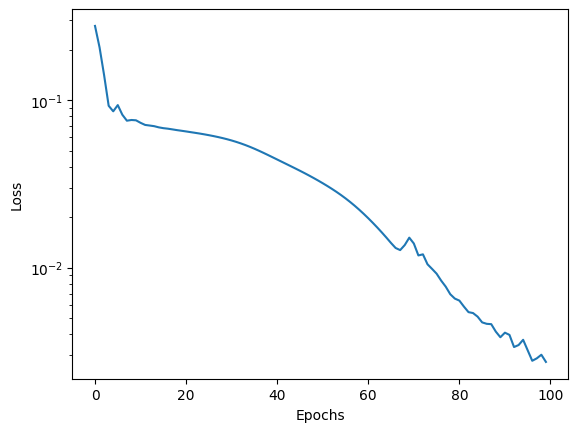

In [7]:
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.semilogy()
plt.show()

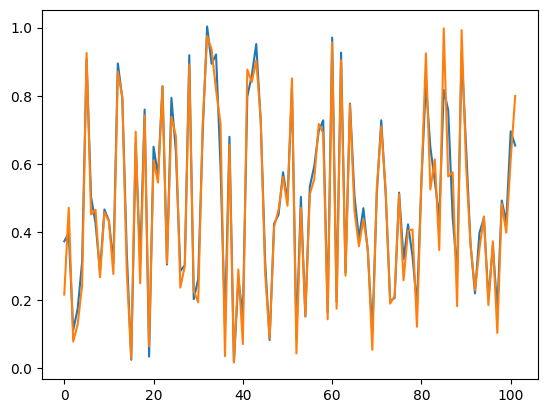

In [ ]:
results2 = fno1(x[0, :, :])
plt.plot(results2)
plt.plot(y[0, :, :])
plt.show()